# Notebook to analyze spike count within burst

## Imports

In [251]:
import os 
import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# from matplotlib import rcParams
from mosquito.process_abf import load_processed_data
from mosquito.analyze_bursts import detect_burst_peaks, realign_spikes, peak_detection_test
from mosquito.util import iir_notch_filter, butter_highpass_filter, butter_bandpass_filter, moving_avg


## Params

In [252]:
# which example fly to look at 
data_folder =  '24_20240520'  #'22_20240516'  #  '23_20240517'  # '28_20240529'  #    '22_20240516' # '19_20240510'  # '24_20240520'  # '22_20240516'  # 
axo_num = 8  # 4 # 6  # 1  #        9  # 4  #  1  # 7  #  6  # 2


In [253]:
# which set of flies to look at
data_files = [19.1, 19.2, 19.4, 19.5, 19.6,
              22.0, 22.1, 22.2, 22.4, 22.5, 22.6, 22., 22.8, 22.9, 22.12,
              23.0, 23.1, 23.2, 23.3, 23.4, 23.5, 23.6, 
              24.7, 24.8, 
              26.1, 26.2, 26.3, 
              28.0, 28.1, 28.2, 28.5, 28.6, 28.8, 28.9, 
              29.7, 29.8]


In [254]:
# plot params
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels

## Helper functions


In [255]:
def get_burst_peaks_all(data):
    """
    Wrapper function for detect_burst_peaks that should let me get peak numbers from a full 
    trial data file
    
    """
    spike_idx = data['spike_idx']
    emg = data['emg']
    t = data['time']
    
    n_peaks_list = list()
    
    for idx in spike_idx:
        peaks, peaks_df = detect_burst_peaks(emg, t, idx, viz_flag=False)
        n_peaks_list.append(peaks.size)

    return n_peaks_list
    

In [256]:
def sliding_avg(x, w=3):
    """
    Implementation from stack overflow

    https://stackoverflow.com/questions/13728392/moving-average-or-running-mean/60673218#60673218
    
    """
    # x_ = np.insert(x, 0, 0)
    # sliding_average = x_[:w].sum() / w + np.cumsum(x_[w:] - x_[:-w]) / w
    # return sliding_average
    x_ser = pd.Series(data=x)
    sliding_average = x_ser.rolling(w).mean()
    return sliding_average.values
    
    

In [257]:
def moving_slope(vec, supportlength=3, modelorder=1, dt=1):
    """
    Estimate local slope for a sequence of points, using a sliding window

    movingslope uses filter to determine the slope of a curve stored
    as an equally (unit) spaced sequence of points. A patch is applied
    at each end where filter will have problems. A non-unit spacing
    can be supplied.
    
    Note that with a 3 point window and equally spaced data sequence,
    this code should be similar to gradient. However, with wider
    windows this tool will be more robust to noisy data sequences.

    From https://www.mathworks.com/matlabcentral/fileexchange/16997-movingslope

    Arguments:
        vec - row of column vector, to be differentiated. vec must be of
            length at least 2.

        supportlength - (OPTIONAL) scalar integer - defines the number of
            points used for the moving window. supportlength may be no
            more than the length of vec.
        
            supportlength must be at least 2, but no more than length(vec)
        
            If supportlength is an odd number, then the sliding window
            will be central. If it is an even number, then the window
            will be slid backwards by one element. Thus a 2 point window
            will result in a backwards differences used, except at the
            very first point, where a forward difference will be used.
        
            DEFAULT: supportlength = 3
        
        modelorder - (OPTIONAL) - scalar - Defines the order of the windowed
            model used to estimate the slope. When model order is 1, the
            model is a linear one. If modelorder is less than supportlength-1.
            then the sliding window will be a regression one. If modelorder
            is equal to supportlength-1, then the window will result in a
            sliding Lagrange interpolant.
        
            modelorder must be at least 1, but not exceeding
            min(10,supportlength-1)
        
            DEFAULT: modelorder = 1
        
        dt - (OPTIONAL) - scalar - spacing for sequences which do not have
            a unit spacing.
        
            DEFAULT: dt = 1

    Returns:
        Dvec = vector of derivative estimates, Dvec will be of the same size
            and shape as is vec.
    """
    # helper function to get filter coefficients
    def getcoef(t, supportlength, modelorder):
        a = (np.tile(t, (modelorder+1, 1)).T)**np.tile(np.arange(modelorder+1), (supportlength,1))
        pinva = np.linalg.pinv(a)
        coef = pinva[1,:]
        return coef

    # length of input vector
    n = vec.size
    
    # build filter coefficients to estimate slope
    if (supportlength % 2) == 1:
        parity = 1  # odd parity
    else:
        parity = 0  # even parity
        
    s = (supportlength - parity)/2
    t = np.arange(-s + 1 - parity, s + 1)
    coef = getcoef(t, supportlength, modelorder)

    # Apply the filter to the entire vector
    f = signal.lfilter(-coef, 1, vec)
    Dvec = np.zeros(vec.shape)
    idx = slice(int(s + 1), int(s + n - supportlength))
    Dvec[idx] = f[supportlength:-1]

    # Patch each end
    for ith in range(int(s)):
        # patch the first few points
        t = np.arange(supportlength) - ith
        coef = getcoef(t, supportlength, modelorder)
        Dvec[ith] = np.dot(coef, vec[:supportlength])

        # patch the end points
        if ith<(s + parity):
            t = np.arange(supportlength) - supportlength + ith - 1;
            coef = getcoef(t,supportlength,modelorder);
            Dvec[n - ith - 1] = np.dot(coef, vec[n + np.arange(supportlength) - supportlength]);
        
    return Dvec

In [258]:
def detect_burst_peaks_new(emg, burst_idx, window=1028, height_factor=0.1,
                           width_bounds=(20, 100), emg_filt=None, viz_flag=False):
    """
    Attempt to update peak detection method 


    TO DO: make the selection of height and width bounds based on data
    
    """
    # get waveform of current burst
    idx_range = np.arange(burst_idx - window, burst_idx + window)
    burst_waveform = emg[idx_range] - emg[idx_range][0]

    # find derivative points corresponding to pre-spike rises
    burst_waveform_dot = moving_slope(burst_waveform, supportlength=101, modelorder=7)
    height_bounds = (height_factor*np.max(burst_waveform_dot), None)
    deriv_peaks, props = signal.find_peaks(burst_waveform_dot, 
                                           height=height_bounds,
                                           width=width_bounds)

    # check that we found peaks at all
    if (deriv_peaks.size < 2) or any(np.isnan(deriv_peaks)):
        return None
        
    # insert a guess for a right bound of the final peak
    final_deriv_peak = round(2*np.mean(np.diff(deriv_peaks)) + deriv_peaks[-1])
    deriv_peaks = np.append(deriv_peaks, final_deriv_peak)

    # get the minima between derivative peaks (~ zero crossings)
    peaks = []
    for pk1, pk2 in zip(deriv_peaks[:-1], deriv_peaks[1:]):
        # get minimum between adjacent peaks
        # idx = np.argmin(np.abs(spike_mean_dot[pk1:pk2])) + pk1 - 1
        # idx = np.argmax(spike_mean[pk1:pk2]) + pk1
        peaks_tmp, _ = signal.find_peaks(burst_waveform[pk1:pk2])
        if peaks_tmp.size > 0:
            idx = peaks_tmp[0] + pk1
        else:
            idx = np.argmin(np.abs(burst_waveform_dot[pk1:pk2])) + pk1
            
        peaks.append(idx)

    peaks = np.asarray(peaks)

    # use filtered data to check peak location
    if emg_filt is not None:
        # smoothed out waveform for current burst
        burst_waveform_filt = emg_filt[idx_range]

        # get maximum of filtered burst
        burst_max = np.max(burst_waveform_filt)
        max_idx = np.argmax(burst_waveform_filt)

        # first point to the left of the maximum that dips below X%
        pre_idx = np.where(burst_waveform_filt[:max_idx] > 0.2*burst_max)[0]
        if pre_idx.size > 0:
            left_idx = pre_idx[0]
        else:
            left_idx = 0

        # first point to the right of the maximum that dips below X%
        post_idx = np.where(burst_waveform_filt[max_idx:] < 0.2*burst_max)[0]
        if post_idx.size > 0:
            right_idx = post_idx[0]
            right_idx += max_idx
        else:
            right_idx = 2*window

        # use these to restrict peak locations
        keep_idx = (peaks > left_idx) & (peaks < right_idx)
        peaks = peaks[keep_idx]
        
    # visualize?
    if viz_flag:
        fig, ax = plt.subplots()
        ax.plot(idx_range, burst_waveform)
        ax.plot(idx_range[peaks], burst_waveform[peaks], 'rx')

        ax.set_xlabel('x (index)')
        ax.set_ylabel('emg (V)')
        ax.set_title(f'{peaks.size} peaks')
        
        plt.show()

    # get peaks in global index
    peaks += idx_range[0]
    
    # return
    return peaks
    

## Load data

In [259]:
# load example data set
data = load_processed_data(data_folder, axo_num)


In [260]:
# Get burst info
spike_idx = data['spike_idx']
spikes = data['spikes']
emg = data['emg']
t = data['time']
window = round(data['params']['emg_window']/2)
fs = data['sampling_freq'] 
wbf = data['wbf']
flying_idx = data['flying_idx']


## Test current spike detection method

In [261]:
# get number of peaks per burst. first filter
lowcut = np.floor(np.min(wbf[flying_idx]))
highcut = np.ceil(np.max(wbf[flying_idx]))
# emg = detrend_emg(emg)
emg_filt_new = butter_bandpass_filter(emg, lowcut, highcut, 1 / fs, order=25, btype='stop')
emg_filt_new = moving_avg(emg_filt_new, k=7)

n_peaks_list = list()

for ith, idx in enumerate(spike_idx):
    # print(ith)
    peaks = detect_burst_peaks(emg_filt_new, idx, min_prom_factor=0.025, viz_flag=False, emg_filt=data['emg_filt'])
    if peaks is not None:
        n_peaks_list.append(peaks.size)

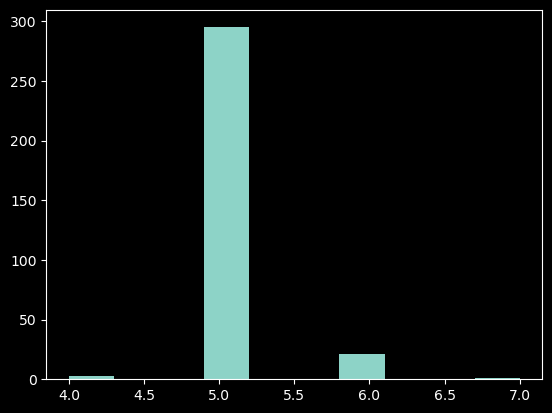

In [262]:
# plot distribution of spike numbers
fig, ax = plt.subplots()
ax.hist(n_peaks_list) ; 

In [263]:
# find bursts with odd peak numbers
low_ind = np.where(np.asarray(n_peaks_list) == 4)[0]
print(low_ind)

high_ind = np.where(np.asarray(n_peaks_list) == 6)[0]
print(high_ind)

[130 247 312]
[ 13  26  51 ... 253 259 313]


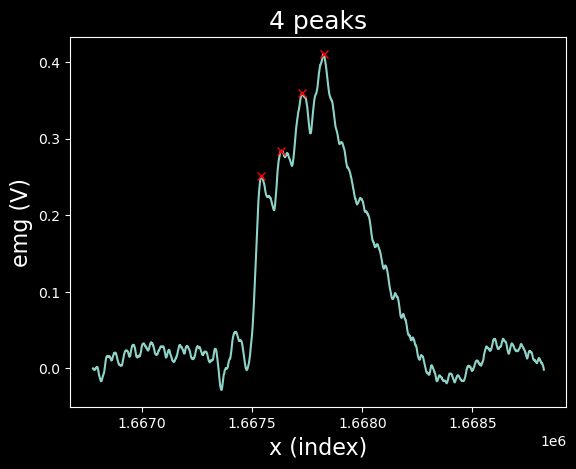

In [264]:
# visualize this signal
viz_ind = spike_idx[low_ind[0]]  #  spike_idx[high_ind[0]]
peaks = detect_burst_peaks(emg_filt_new, viz_ind, min_prom_factor=0.025, viz_flag=True, emg_filt=data['emg_filt'])

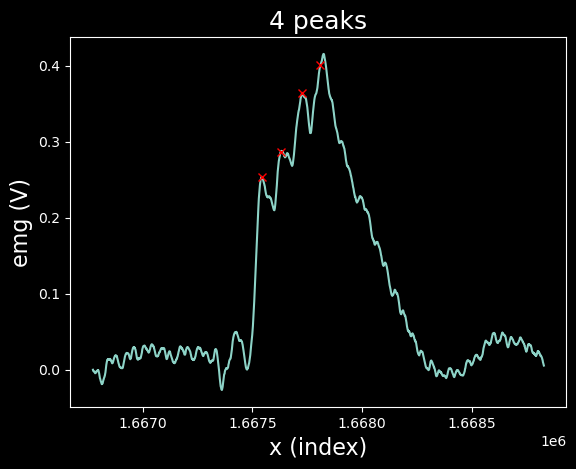

In [265]:
# in current example, spikes are too shallow to be detected. will derivative perform better?
# idx_range = np.arange(viz_ind - window, viz_ind + window)
# burst_waveform = emg_filt_new[idx_range]
peaks = detect_burst_peaks_new(emg_filt_new, viz_ind, viz_flag=True, emg_filt=data['emg_filt'])

## Test method that uses peak finding with derivative

In [266]:
# get number of peaks per burst. first filter
lowcut = np.floor(np.min(wbf[flying_idx]))
highcut = np.ceil(np.max(wbf[flying_idx]))
# emg = detrend_emg(emg)
emg_filt_new = butter_bandpass_filter(emg, lowcut, highcut, 1 / fs, order=25, btype='stop')
emg_filt_new = moving_avg(emg_filt_new, k=7)

# fill nan values
nan_ind = np.isnan(emg_filt_new)
tmp_range = np.arange(emg.size)
emg_filt_new[nan_ind] = np.interp(tmp_range[nan_ind], tmp_range[~nan_ind], emg_filt_new[~nan_ind])

# get peaks
n_peaks_new_list = list()

for ith, idx in enumerate(spike_idx):
    # print(ith)
    peaks = detect_burst_peaks_new(emg_filt_new, idx, viz_flag=False, emg_filt=data['emg_filt'])
    if peaks is not None:
        n_peaks_new_list.append(peaks.size)

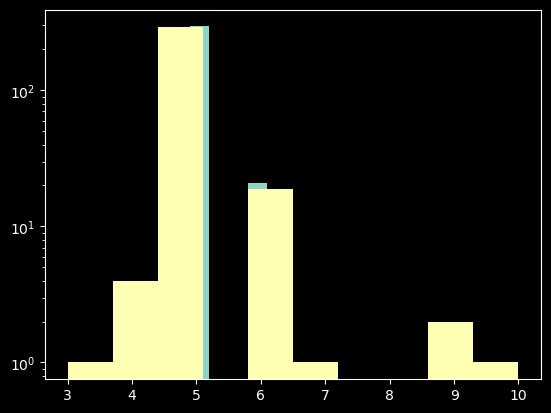

In [267]:
fig, ax = plt.subplots()
ax.hist(n_peaks_list) ; 
ax.hist(n_peaks_new_list) ; 
ax.set_yscale('log')

In [268]:
# # new method attempt
# emg_filt_new = butter_bandpass_filter(emg, round(np.min(wbf)), round(np.max(wbf)), 1/fs, btype='stop', order=11) 
# peaks = detect_burst_peaks_new(emg, t, spike_idx[76], viz_flag=True, height_bounds=(0.002, None))


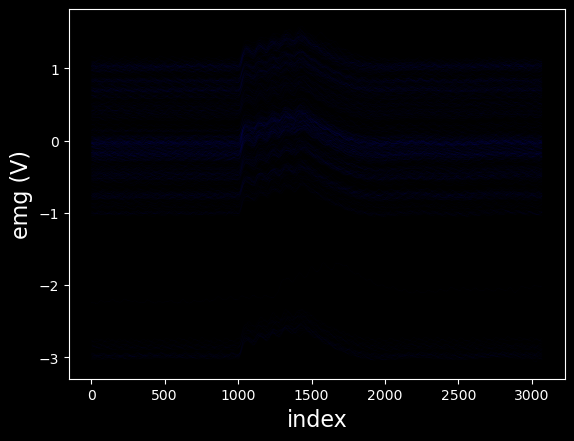

In [269]:
# try to just get average
spikes_realigned, _ = realign_spikes(spikes, spike_idx, emg, window,thresh_factor=0.3, viz_flag=True)

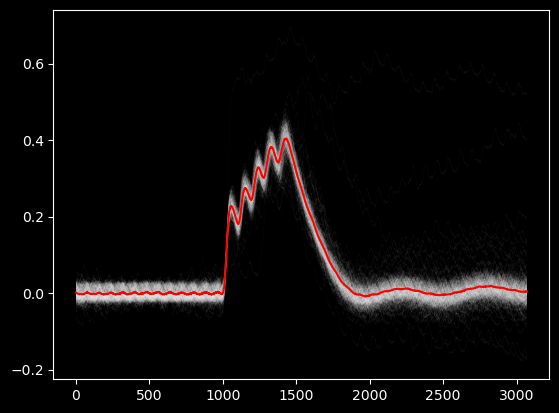

In [270]:
# zero the initial portion of spike waveform
spikes_array = np.vstack(spikes_realigned)
spikes_array -= np.reshape(np.mean(spikes_array[:, :window], axis=1), (-1, 1))
# spikes_array -= np.reshape(spikes_array[:,0], (-1, 1))

fig, ax = plt.subplots()

for spike in spikes_array:
    ax.plot(spike, lw=0.1, alpha=0.1, color='w')

ax.plot(np.mean(spikes_array, axis=0), 'r-')

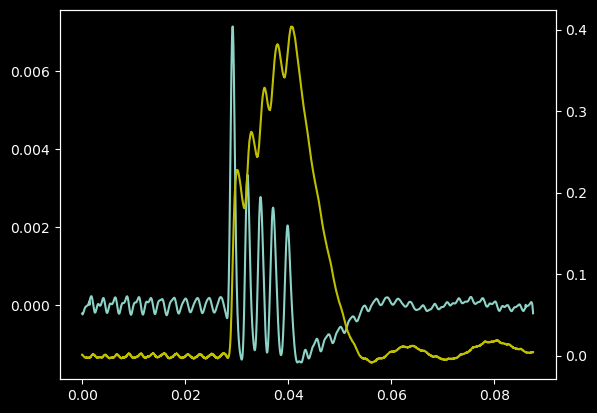

In [271]:
# look at derivative of spike waveform
spike_mean = np.mean(spikes_array, axis=0)
spike_t = (1/fs)*np.arange(spike_mean.size)

fig, ax = plt.subplots()

spike_mean_dot = moving_slope(spike_mean, supportlength=101, modelorder=7)
# spike_mean_dot = np.gradient(spike_mean)

ax.plot(spike_t, spike_mean_dot)
ax1 = ax.twinx()
ax1.plot(spike_t, spike_mean, color='y')

In [272]:
# # TEMP test a less hard-coded way of setting height thresh
# max_idx = np.argmax(spike_mean)
# spike_mean_rise = spike_mean[max_idx] - 

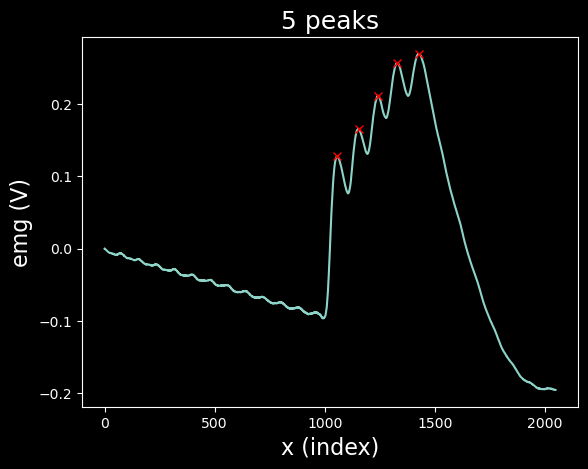

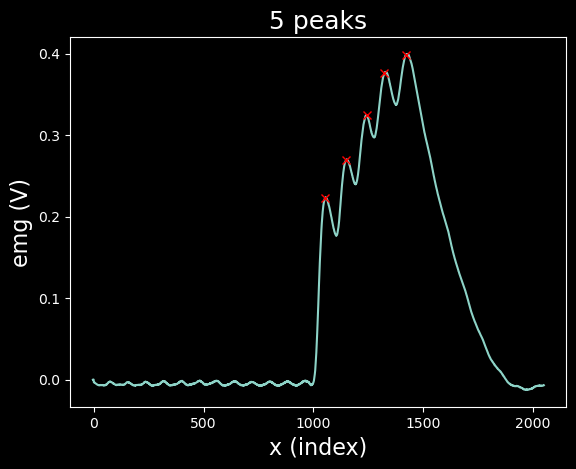

In [273]:
# try detect peaks method on mean
peaks = detect_burst_peaks(spike_mean, window, viz_flag=True)
peaks_new = detect_burst_peaks_new(spike_mean, window, viz_flag=True)

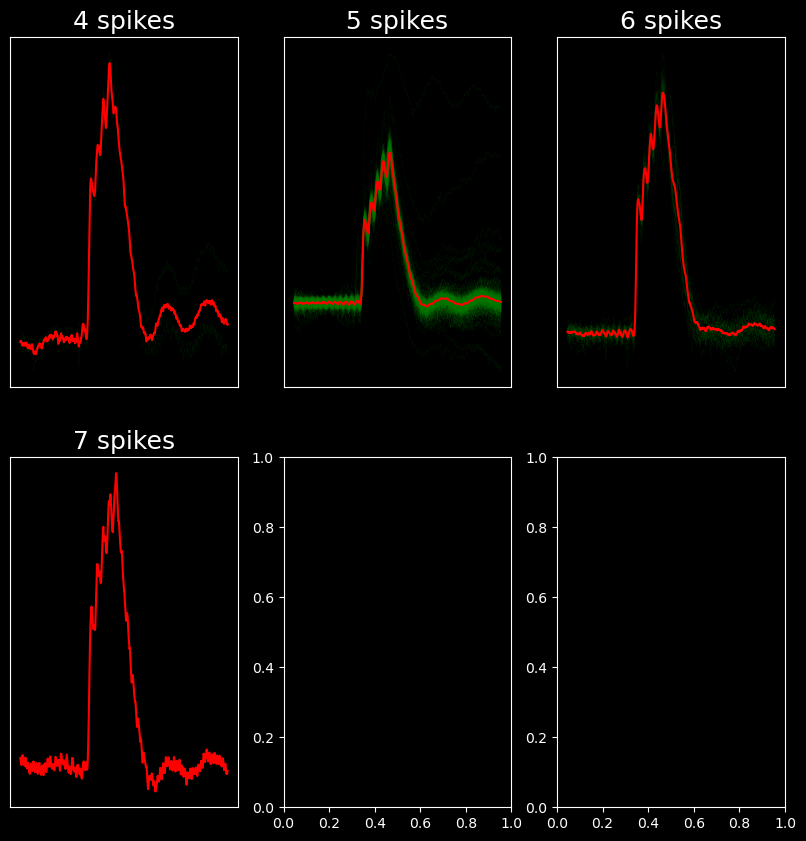

(<Figure size 1000x1000 with 6 Axes>,
 array([<Axes: title={'center': '4 spikes'}>,
        <Axes: title={'center': '5 spikes'}>,
        <Axes: title={'center': '6 spikes'}>,
        <Axes: title={'center': '7 spikes'}>, <Axes: >, <Axes: >],
       dtype=object),
 array([5, 5, 5, ..., 5, 5, 5]))

In [274]:
peak_detection_test(data)

## Quick savitzky golay test

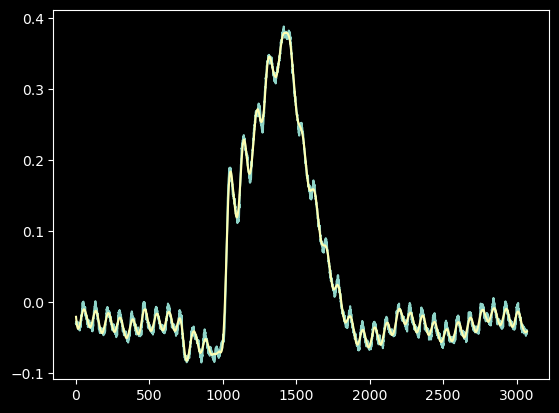

In [279]:
# test filtering
spike_ex = spikes_realigned[23]
spike_ex_filt = signal.savgol_filter(spike_ex, 71, 3)

fig, ax = plt.subplots()

ax.plot(spike_ex)
ax.plot(spike_ex_filt)

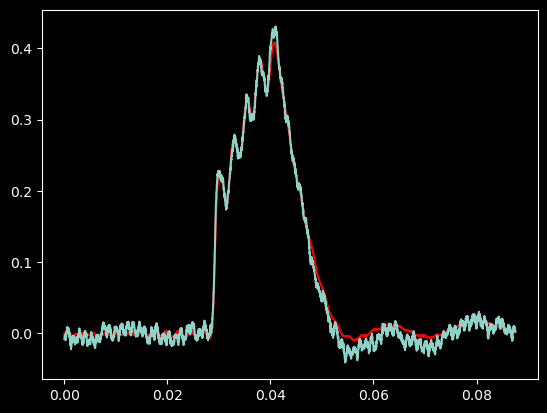

In [365]:
# do general spike peaks line up with mean? I think they do
fig, ax = plt.subplots()

ax.plot(spike_t, spike_mean, 'r')
ax.plot(spike_t, spikes_array[76, :])

[1025 1121 1227 1309 1395]


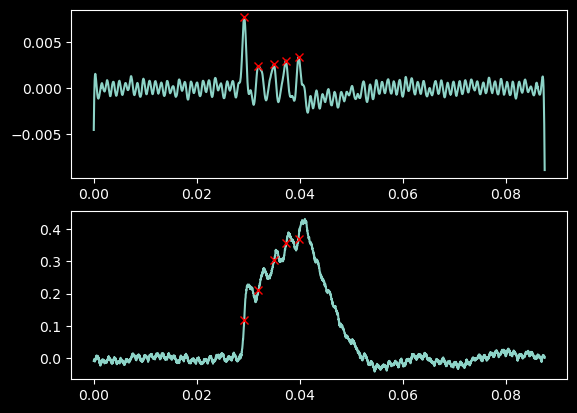

In [379]:
# get peaks in derivative
spike_mean_dot = moving_slope(spike_mean, supportlength=101, modelorder=7)
deriv_peaks, props = signal.find_peaks(spike_mean_dot, 
                                       height=(0.002, None),
                                       width=(20, 100))

print(deriv_peaks)

# visualize
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(spike_t, spike_mean_dot)
ax1.plot(spike_t[deriv_peaks], spike_mean_dot[deriv_peaks], 'rx')

ax2.plot(spike_t, spike_mean)
ax2.plot(spike_t[deriv_peaks], spike_mean[deriv_peaks], 'rx')

In [380]:
# insert a guess for a right bound of the final peak
final_deriv_peak = round(2*np.mean(np.diff(deriv_peaks)) + deriv_peaks[-1])
print(deriv_peaks)
deriv_peaks = np.append(deriv_peaks, final_deriv_peak)
print(deriv_peaks)

[1025 1121 1227 1309 1395]
[1025 1121 1227 1309 1395 1580]


In [381]:
# get the minima between derivative peaks (~ zero crossings)
sig_peaks = []
for pk1, pk2 in zip(deriv_peaks[:-1], deriv_peaks[1:]):
    # get minimum between adjacent peaks
    # idx = np.argmin(np.abs(spike_mean_dot[pk1:pk2])) + pk1 - 1
    # idx = np.argmax(spike_mean[pk1:pk2]) + pk1
    peaks, _ = signal.find_peaks(spike_mean[pk1:pk2])
    if peaks.size > 0:
        idx = peaks[0] + pk1
    else:
        idx = np.argmin(np.abs(spike_mean_dot[pk1:pk2])) + pk1
        
    sig_peaks.append(idx)
    

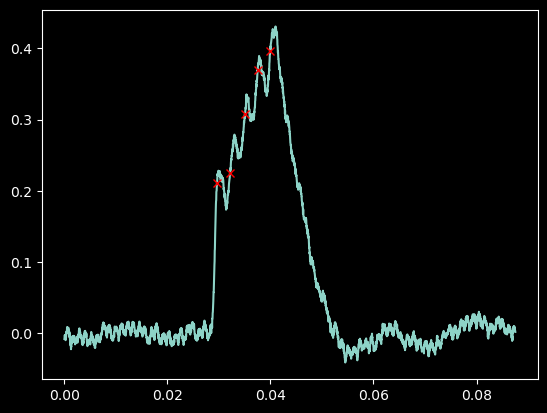

In [382]:
# visualize
fig, ax = plt.subplots()

ax.plot(spike_t, spike_mean)
ax.plot(spike_t[sig_peaks], spike_mean[sig_peaks], 'rx')

# ax.set_xlim([0.027, 0.032])

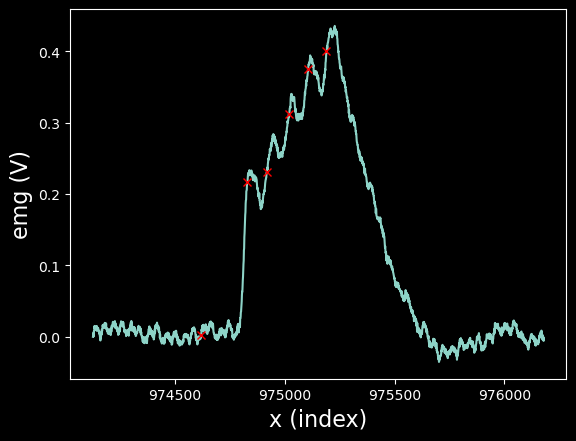

array([974617, 974828, 974917, 975018, 975105, 975189])

In [375]:
detect_burst_peaks_new(emg_filt_new, t, spike_idx[76], viz_flag=True)

This seems to be doing okay, but try more. Also still need to get last spike. Maybe estimate ISI and then make a guess at another boundary point to append to end? i.e. something like deriv_peaks.append(deriv_peaks[-1] + 2*np.mean(np.diff(deriv_peaks))), where the factor of 2 is to ensure we're not missing something (and can be increased)

In [250]:
print(spike_mean[(sig_peaks[0] - 2):(sig_peaks[0] + 2)])

[0.2341 0.2345 0.2359 0.2357]


In [251]:
print(spike_mean[sig_peaks[0]])

0.23586273


## Filtered signal to bracket valid peak locations

In [436]:
# look at example waveform
ex_ind = 76

burst_waveform_filt = spikes[ex_ind]

burst_max = np.max(burst_waveform_filt)
max_idx = np.argmax(burst_waveform_filt)
left_idx = np.where(burst_waveform_filt[:max_idx] > 0.2*burst_max)[0][0]
right_idx = np.where(burst_waveform_filt[max_idx:] < 0.2*burst_max)[0][0]
right_idx += max_idx

## Scratch

In [9]:
def getcoef(t, supportlength, modelorder):
        a = (np.tile(t, (modelorder+1, 1)).T)**np.tile(np.arange(modelorder+1), (supportlength,1))
        pinva = np.linalg.pinv(a)
        coef = pinva[1,:]
        return coef

In [417]:
# testing for function
vec = spike_mean
n = vec.size
supportlength = 3
modelorder=1

parity = supportlength % 2
s = (supportlength - parity)/2
t = np.arange(-s + 1 - parity, s+1)

coef = getcoef(t, supportlength, modelorder)

f = signal.lfilter(-coef, 1, vec)
Dvec = np.zeros(vec.shape)
idx = slice(int(s + 1), int(s + n - supportlength))
Dvec[idx] = f[supportlength:-1]


In [433]:
np.where(spike_mean > 0.1)[0][-1]

1694

In [418]:
ith = 0 
t = np.arange(supportlength) - ith
coef = getcoef(t, supportlength, modelorder)



In [419]:
print(coef.shape)
print(vec[:supportlength].shape)

(3,)
(3,)


In [420]:
# vec = spike_mean
# Dvec = moving_slope(vec)

In [421]:
# sig = np.gradient(spike_mean)
# sig_noise = Dvec

# corr = signal.correlate(sig_noise, sig)
# lags = signal.correlation_lags(len(sig), len(sig_noise))
# corr /= np.max(corr)


# fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, figsize=(4.8, 4.8))
# ax_orig.plot(sig)
# ax_orig.set_title('Original signal')
# ax_orig.set_xlabel('Sample Number')
# ax_noise.plot(sig_noise)
# ax_noise.set_title('Signal with noise')
# ax_noise.set_xlabel('Sample Number')
# ax_corr.plot(lags, corr)
# ax_corr.set_title('Cross-correlated signal')
# ax_corr.set_xlabel('Lag')
# ax_orig.margins(0, 0.1)
# ax_noise.margins(0, 0.1)
# ax_corr.margins(0, 0.1)
# fig.tight_layout()
# plt.show()

# max_corr_idx = np.argmax(corr)
# print(lags[max_corr_idx])

In [366]:
# # try spline fit to get smoother derivative
# from scipy.interpolate import CubicSpline

# cs = CubicSpline(spike_t, spike_mean)

# # plt.plot(spike_t, spike_mean)
# # plt.plot(spike_t, cs(spike_t))
# plt.plot(spike_t, fs*np.gradient(spike_mean))
# plt.plot(spike_t, cs(spike_t, 1))

In [367]:
# # try smoothed signal
# spike_mean_smooth = sliding_avg(spike_mean, w=15)

# # plt.plot(np.gradient(spike_mean))
# # plt.plot(np.gradient(spike_mean_smooth))
# plt.plot(moving_slope(spike_mean, supportlength=101, modelorder=7))
# # plt.xlim([1000, 1200])

In [368]:
# # compare movingslope and np.gradient
# grad_output = np.gradient(spike_mean)
# ms_output = moving_slope(spike_mean)

# fig, ax = plt.subplots()
# ax.plot(spike_t, grad_output)
# ax.plot(spike_t, ms_output)

# print(np.sum(grad_output - ms_output))

In [369]:
spike_mean = spikes_array[76, :]

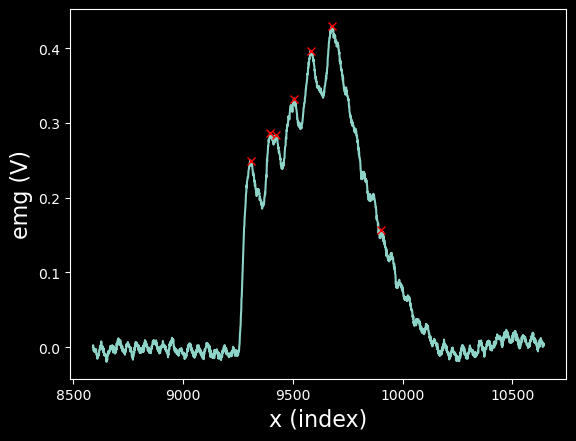

In [428]:
# # old method
# emg_filt_new = butter_bandpass_filter(emg, np.floor(np.min(wbf)), np.ceil(np.max(wbf)), 1/fs, btype='stop', order=12) 
# # emg_filt_new = sliding_avg(emg_filt_new, w=7)
# peaks = detect_burst_peaks(emg_filt_new, spike_idx[0], min_prom_factor=0.025, viz_flag=True)
